In [2]:
from controller import Imager

In [3]:
imager = Imager()

Found 1 devices
Devices IDs - ['101936']


In [4]:
imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'
imager.update_params(ExposureTime=20000, AcquisitionFrameRate = 5)

In [5]:
PIXELFORMATS = {'8':'Mono8','12':'Mono12Packed'}
PIXELFORMAT = PIXELFORMATS['8']
imager.update_params(ExposureTime=20000, PixelFormat=PIXELFORMAT, AcquisitionFrameRate = 50)

In [6]:
imager._start_acquisitions()

0 - 2021-07-26 16:22:04.641765 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:07.050673 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:09.475219 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:11.973138 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:14.439863 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:16.908989 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:19.378433 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:21.861863 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:24.441002 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:26.912821 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:29.312788 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:31.801663 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:34.183619 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:36.593951 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:39.004221 - 101936 captured Mono8 image 
0 - 2021-07-26 16:22:41.582931 - 101936 captured Mono8 image 


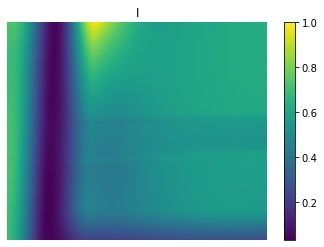

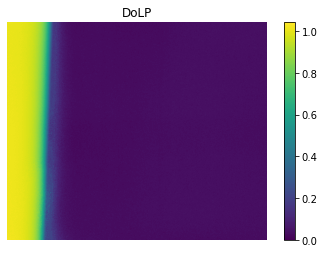

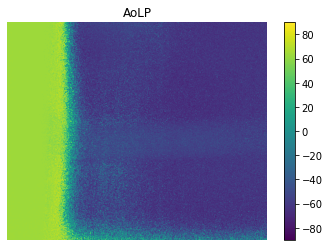

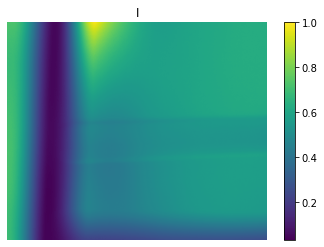

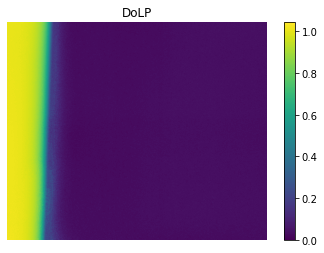

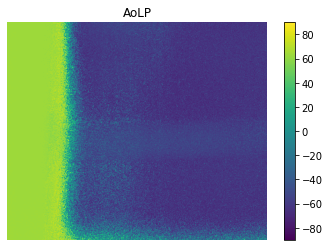

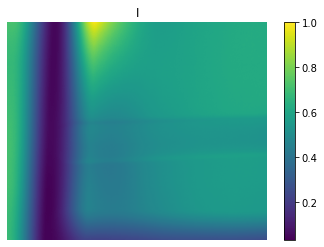

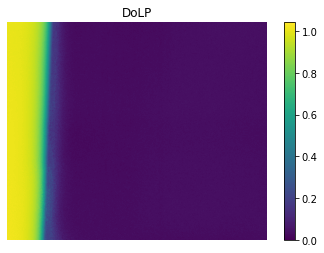

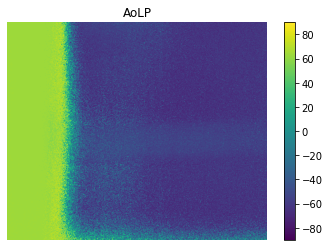

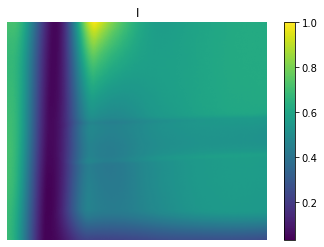

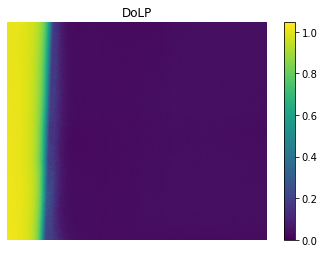

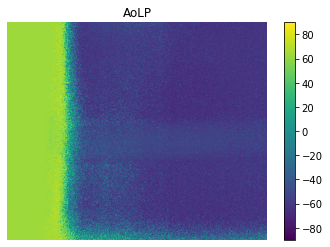

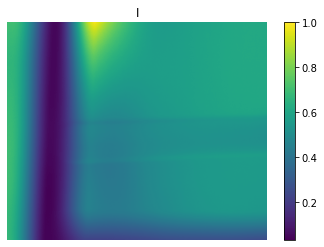

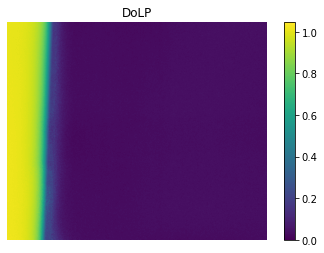

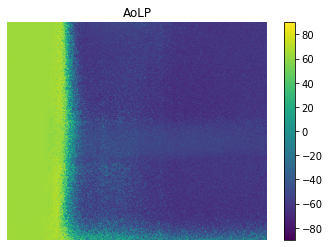

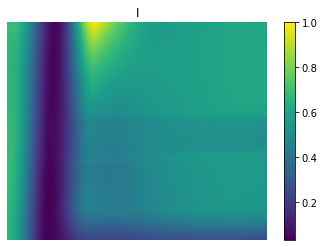

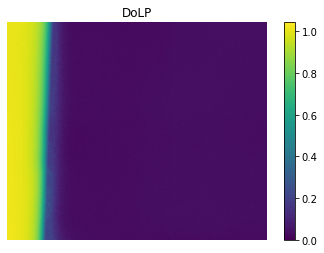

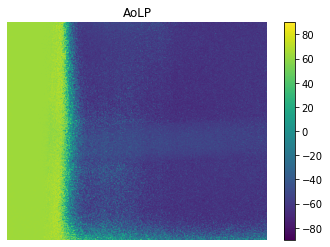

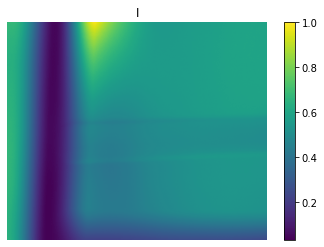

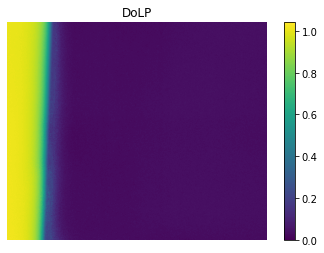

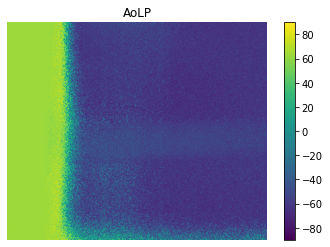

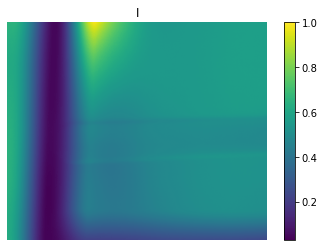

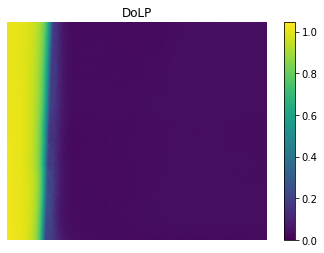

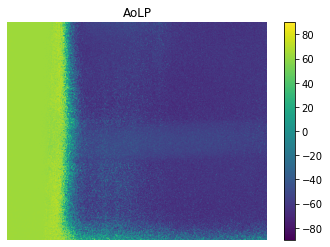

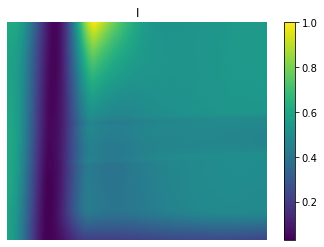

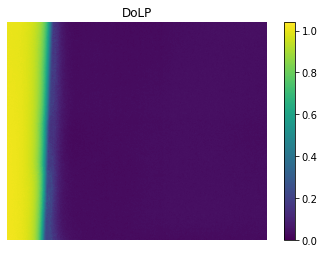

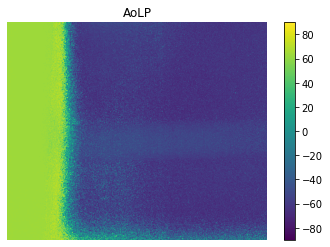

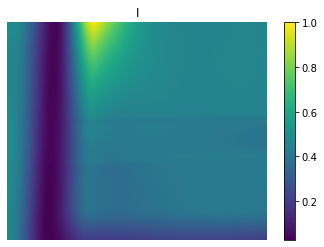

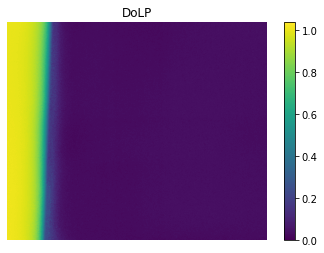

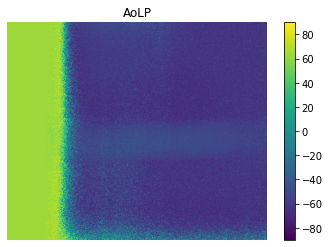

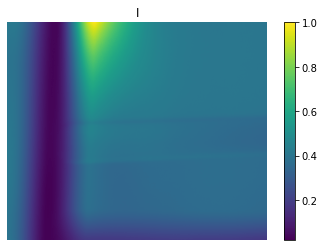

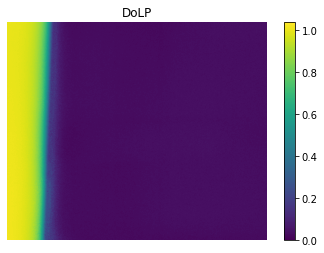

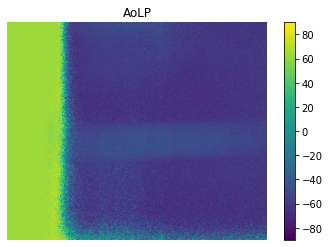

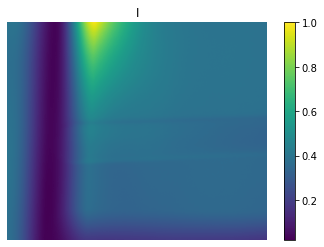

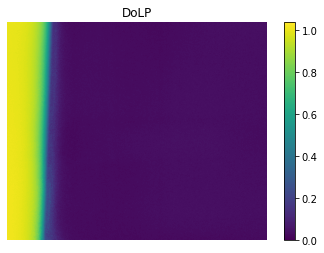

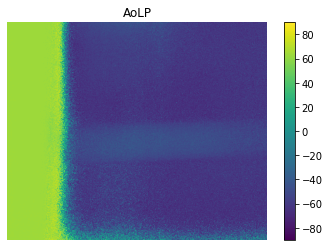

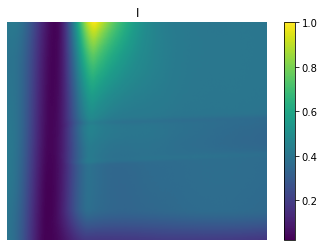

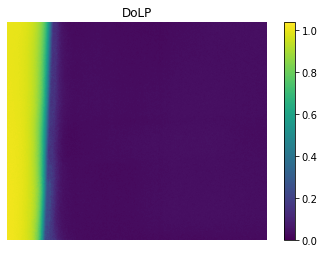

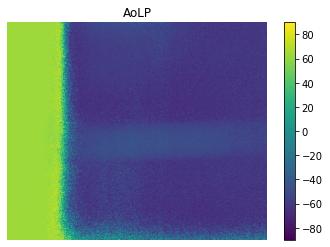

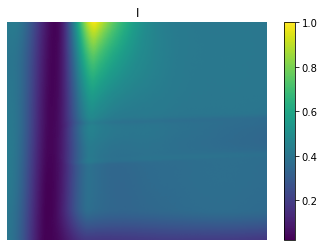

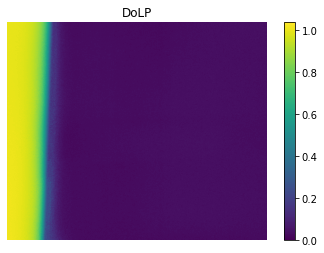

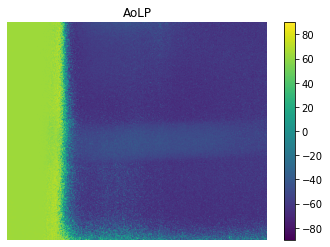

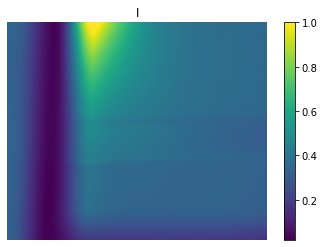

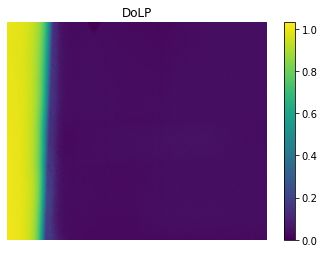

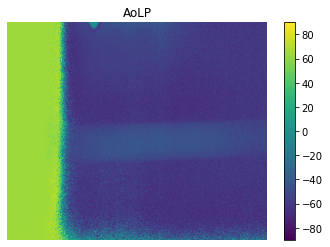

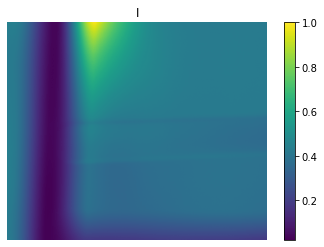

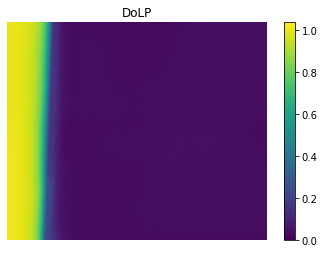

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [9]:
import cv2
import polanalyser as pa
from PIL import Image
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import numpy as np
# Based on https://github.com/elerac/polanalyser

n= 1000
for i in range(n):
    init_image = imager.capture_sequence(num_frames=1, sleep_seconds=0.2)
    init_image = np.squeeze(np.array(init_image[0]))
    img_demosaiced = pa.demosaicing(init_image)
    img_0, img_45, img_90, img_135 = cv2.split(img_demosaiced)
    #Image.fromarray(img_0).show()
    #Image.fromarray(img_45).show()
    #Image.fromarray(img_90).show()
    #Image.fromarray(img_135).show()

    Stokes = pa.calcLinearStokes([img_0, img_45, img_90, img_135], [0,45,90,135])
    I = Stokes[:, :, 0]
    DoLP = pa.cvtStokesToDoLP(Stokes)
    AoLP = (180/np.pi)*pa.cvtStokesToAoLP(Stokes)-90

    plt.figure(1)
    im1 = plt.imshow(I/np.max(I))
    plt.colorbar(im1)
    datacursor()
    plt.title('I')
    plt.axis('off')
    plt.show()
    if i==n:
        plt.savefig('I.png')

    plt.figure(2)
    im2 = plt.imshow(DoLP)
    plt.colorbar(im2)
    datacursor(im2)
    plt.title('DoLP')
    plt.axis('off')
    plt.show()
    if i==n:
        plt.savefig('DoLP.png')

    plt.figure(3)
    im3 = plt.imshow(AoLP)
    plt.colorbar(im3)
    datacursor(im3)
    plt.title('AoLP')
    plt.axis('off')
    plt.show()
    if i==n:
        plt.savefig('AoLP.png')



In [19]:
# imager.get_images(show_images=True, save_images=False)
raw_images = imager.capture_sequence(num_frames=50, sleep_seconds=0.2)


cam 101936 captured image of format Mono8 at 2021-06-16 17:55:51.907006
cam 101934 captured image of format Mono8 at 2021-06-16 17:55:51.908007
cam 101935 captured image of format Mono8 at 2021-06-16 17:55:51.909007
cam 101933 captured image of format Mono8 at 2021-06-16 17:55:51.911007
cam 101936 captured image of format Mono8 at 2021-06-16 17:55:52.168678
cam 101934 captured image of format Mono8 at 2021-06-16 17:55:52.187756
cam 101935 captured image of format Mono8 at 2021-06-16 17:55:52.190510
cam 101933 captured image of format Mono8 at 2021-06-16 17:55:52.191760
cam 101936 captured image of format Mono8 at 2021-06-16 17:55:52.440733
cam 101934 captured image of format Mono8 at 2021-06-16 17:55:52.442734
cam 101935 captured image of format Mono8 at 2021-06-16 17:55:52.443732
cam 101933 captured image of format Mono8 at 2021-06-16 17:55:52.445733
cam 101936 captured image of format Mono8 at 2021-06-16 17:55:52.666638
cam 101934 captured image of format Mono8 at 2021-06-16 17:55:52

In [20]:
imager._stop_acquisitions()

In [8]:
imager.clear_all()


In [22]:
imager.cams[-1].remote_device.node_map.ExposureAuto.value = 'Off'

'Off'

In [10]:
import numpy as np
np.array(raw_images[0]).shape

(5, 2048, 2448)

In [11]:
num_frames =10

arr = np.empty((num_frames,5,2048,2448), dtype='uint8')
for frame_num in range(num_frames):
    arr[frame_num] = np.array(raw_images[frame_num])

In [25]:
import pickle
pickle.dump(raw_images, open("dump3.pkl", 'wb'))

In [14]:
np.save('arr', arr)